In [579]:
import numpy as np
import h5py
from types import SimpleNamespace
import matplotlib.pyplot as plt


In [580]:

with h5py.File("data/data.hdf5") as F:
    T = np.array(F["/T"])
    gridSizes = np.array(F["/gridSizes"])

    # Observables includes information for every grid size.
    Metropolis = SimpleNamespace(
        E=np.array(F["/Metropolis/E"]),
        M=np.array(F["/Metropolis/M"]),
        C=np.array(F["/Metropolis/C"]),
        X=np.array(F["/Metropolis/X"]),
    )

    Wolff = SimpleNamespace(
        E=np.array(F["/Wolff/E"]),
        M=np.array(F["/Wolff/M"]),
        C=np.array(F["/Wolff/C"]),
        X=np.array(F["/Wolff/X"]),
    )


## Derivation of the new Angle after Wolff flip

In [581]:
import sympy as sp

theta1, phi = sp.symbols("theta_1 phi")

# current spin angle
sx = sp.Matrix([sp.cos(theta1), sp.sin(theta1)])
# random reflection angle
r = sp.Matrix([sp.cos(phi), sp.sin(phi)])

# Wolff Formula
p = sx - 2 * (sx.dot(r))*r
p = sp.Matrix([p[0].simplify(), p[1].simplify()])

# Sign flipped = 180° phase shift
p

Matrix([
[-cos(2*phi - theta_1)],
[-sin(2*phi - theta_1)]])

# Metropolis

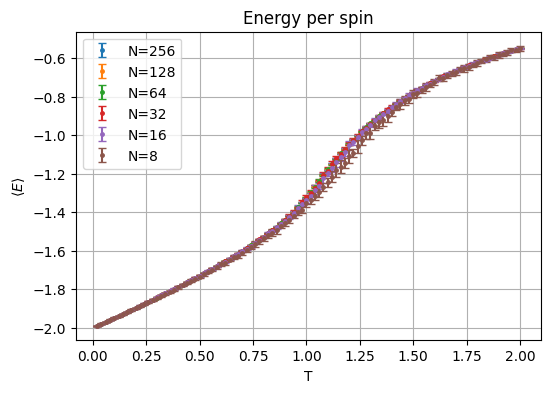

In [582]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Energy per spin")

for i,e in enumerate(Metropolis.E):
    plt.errorbar(T, e.mean(axis=0), e.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle E \rangle$")
plt.grid()
plt.show()

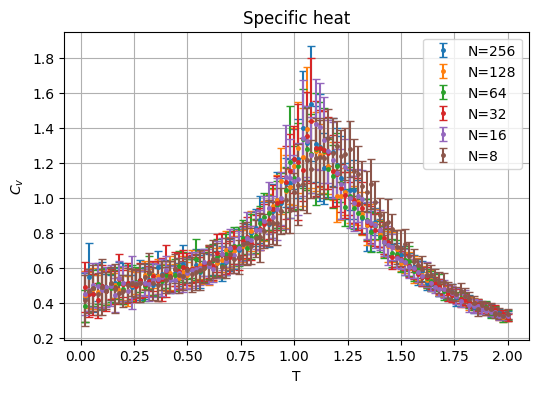

In [583]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Specific heat")

for i, c in enumerate(Metropolis.C):
    plt.errorbar(T, c.mean(axis=0), c.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

# plt.ylim([0, 10])
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$C_v$")
plt.grid()
plt.show()

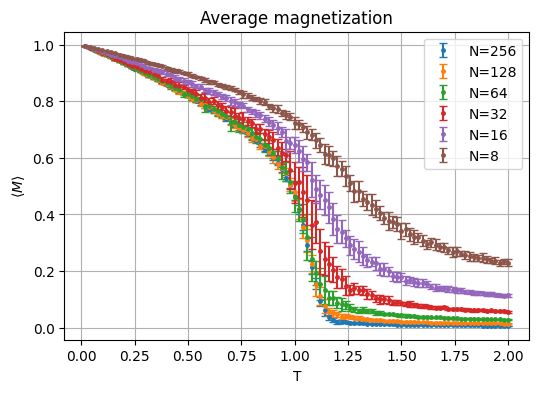

In [584]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Average magnetization")

for i, m in enumerate(Metropolis.M):
    plt.errorbar(T, m.mean(axis=0), m.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle M \rangle$")
plt.grid()
plt.show()

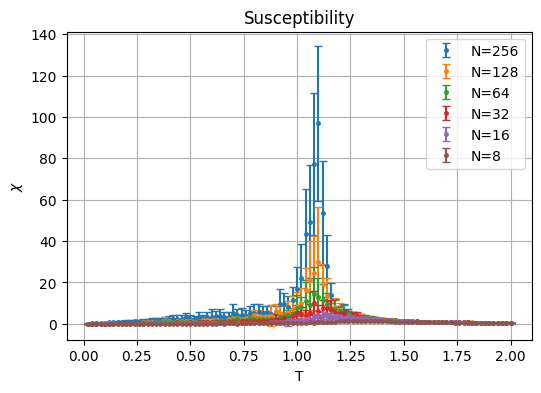

In [585]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Susceptibility")

for i, x in enumerate(Metropolis.X):
    plt.errorbar(T, x.mean(axis=0), x.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\chi$")
plt.grid()
plt.show()

# Wolff

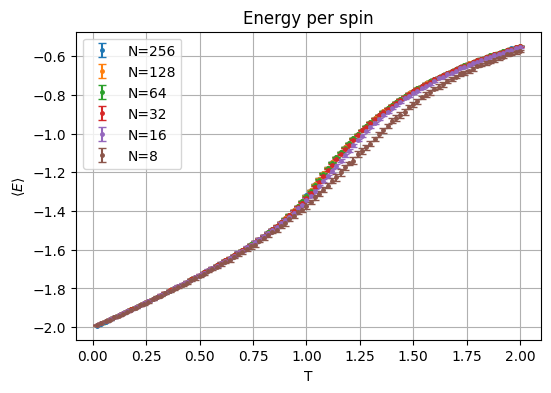

In [586]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Energy per spin")

for i,e in enumerate(Wolff.E):
    plt.errorbar(T, e.mean(axis=0), e.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle E \rangle$")
plt.grid()
plt.show()

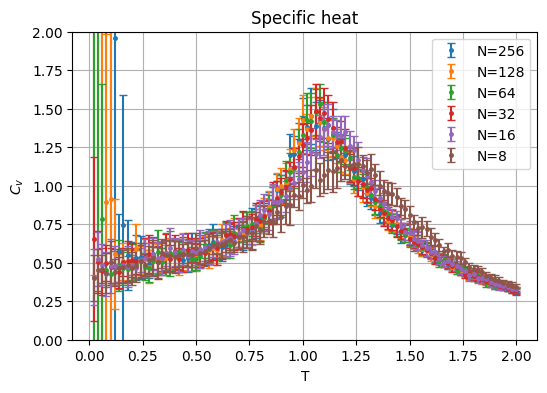

In [587]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Specific heat")

for i, c in enumerate(Wolff.C):
    plt.errorbar(T, c.mean(axis=0), c.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.ylim([0, 2])
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$C_v$")
plt.grid()
plt.show()

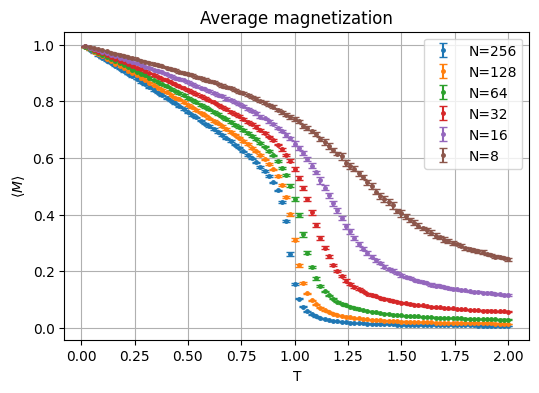

In [588]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Average magnetization")

for i, m in enumerate(Wolff.M):
    plt.errorbar(T, m.mean(axis=0), m.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle M \rangle$")
plt.grid()
plt.show()

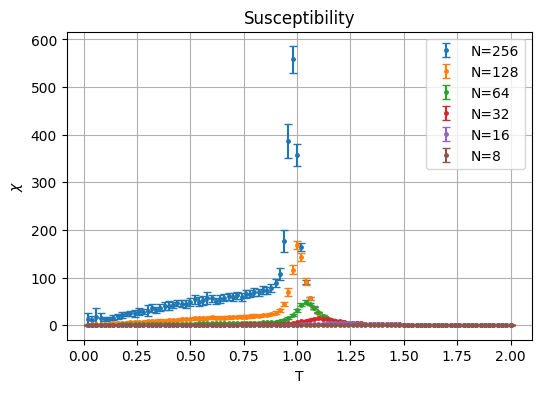

In [589]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Susceptibility")

for i, x in enumerate(Wolff.X):
    plt.errorbar(T, x.mean(axis=0), x.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\chi$")
plt.grid()
plt.show()

# Data Collapse

$$
\chi(L, t) = L^{\gamma/\nu} f(L^{1/\nu} t)
$$

In [590]:
import iminuit

In [591]:
1.85*1.75

3.2375000000000003

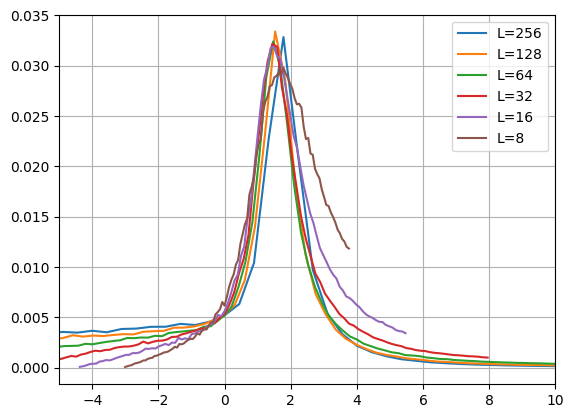

In [592]:
Tc = 0.9
nu = 1.85
gamma = 3.25

for i, x in enumerate(Wolff.X):
    plt.plot((T - Tc)/Tc * gridSizes[i]**(1/nu), x.mean(axis=0) * gridSizes[i]**(-gamma/nu), label=f"L={gridSizes[i]}")

plt.xlim([-5, 10])
# plt.ylim([0.015, 0.035])
plt.legend()
plt.grid()
plt.show()

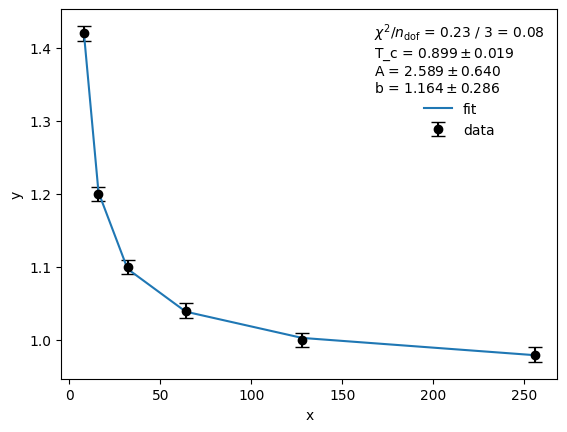

In [568]:
from iminuit.cost import LeastSquares

peaks = [T[np.argmax(Wolff.X[i].mean(axis=0))] for i in range(len(gridSizes))]
peaks_error = np.full_like(peaks, 0.01) # temperature resolution

def line(L, T_c, A, b):
    return T_c + A/np.log(b*L)**2

least_squares = LeastSquares(gridSizes, peaks, peaks_error, line)
m = iminuit.Minuit(least_squares, T_c = 1, A = 1, b = 1)
m.migrad()
m.hesse()

plt.errorbar(gridSizes, peaks, peaks_error, fmt="ok", capsize=5, label="data")
plt.plot(gridSizes, line(gridSizes, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.2f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Autocorrelation time

In [216]:
!cd build/ && make && ./xy_serial

[ 25%] Building CXX object CMakeFiles/xy_serial.dir/main.cpp.o
[ 50%] Linking CXX executable xy_serial
[ 50%] Built target xy_serial
[100%] Built target xy_parallel
^C


In [572]:
T = np.linspace(0.5, 1.5, 20)
with h5py.File("data/autocorrelation.hdf5") as F:
    # T = np.array(F["/T"])
    # tau = np.array(F["Metropolis/C"])
    tau_w = np.array(F["Wolff/C"])

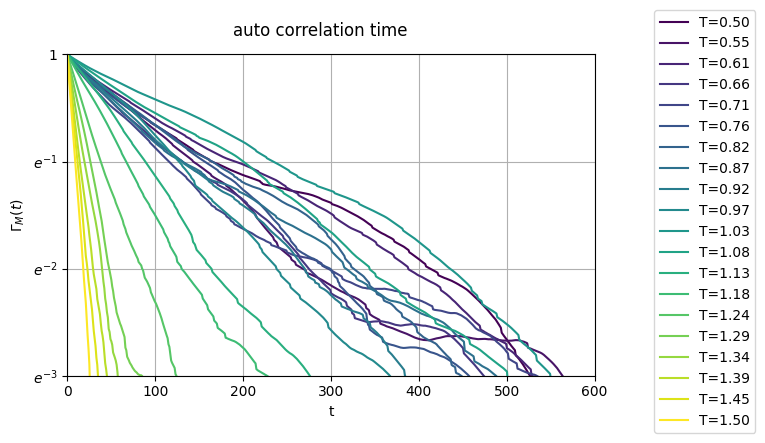

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
fig.tight_layout()
fig.suptitle("auto correlation time")
plt.subplots_adjust(top=0.9)

for i, t in enumerate(tau):
    plt.plot(np.linspace(0, t.size, t.size), t, label=f"T={T[i]:.2f}", c=plt.cm.viridis(i/(len(tau)-1)))

ax.legend(bbox_to_anchor=(1.1, -0.2))
ax.set_xlabel("t")
ax.set_ylabel(r"$\Gamma_M (t)$")

ax.set_xlim([0, 600])
ax.set_yscale("log", base=np.e)
ax.set_ylim([np.exp(-3), 1])
ax.set_yticks([np.exp(0), np.exp(-1), np.exp(-2), np.exp(-3)])
ax.set_yticklabels(['1', '$e^{-1}$', '$e^{-2}$', '$e^{-3}$'])
ax.grid()

plt.show()

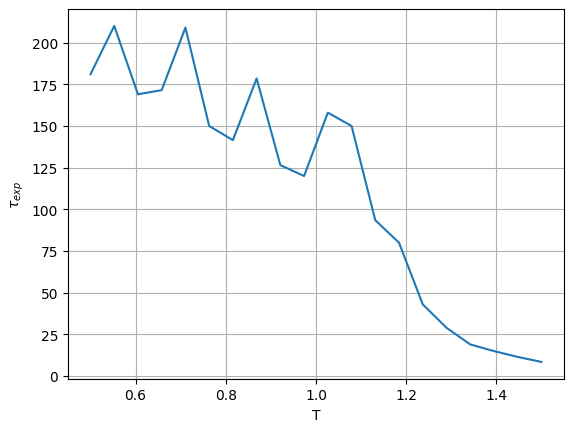

In [ ]:
max_taus = np.zeros(tau.shape[0])

for i, t in enumerate(tau):
    t1 = np.argmax(t < np.exp(-1))
    t3 = np.argmax(t < np.exp(-3))
    max_taus[i] = (t3 - t1) / 2

plt.plot(T, max_taus)
plt.xlabel("T")
plt.ylabel(r"$\tau_{exp}$")
plt.grid()
plt.show()

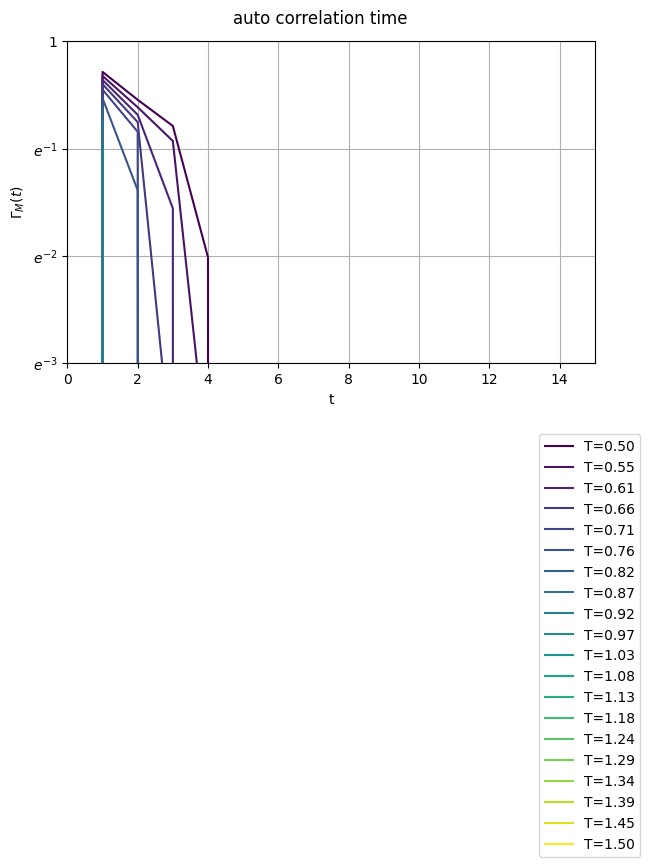

In [577]:
L = 2

fig, ax = plt.subplots(figsize=(6,4))
fig.tight_layout()
fig.suptitle("auto correlation time")
plt.subplots_adjust(top=0.9)

for i, t in enumerate(tau_w[L]):
    plt.plot(np.linspace(0, t.shape[0], t.shape[0]), t.mean(axis=1), label=f"T={T[i]:.2f}", c=plt.cm.viridis(i/(len(tau_w[L])-1)))

ax.legend(bbox_to_anchor=(1.1, -0.2))
ax.set_xlabel("t")
ax.set_ylabel(r"$\Gamma_M (t)$")

ax.set_xlim([0, 15])
ax.set_yscale("log", base=np.e)
ax.set_ylim([np.exp(-3), 1])
ax.set_yticks([np.exp(0), np.exp(-1), np.exp(-2), np.exp(-3)])
ax.set_yticklabels(['1', '$e^{-1}$', '$e^{-2}$', '$e^{-3}$'])
ax.grid()

plt.show()

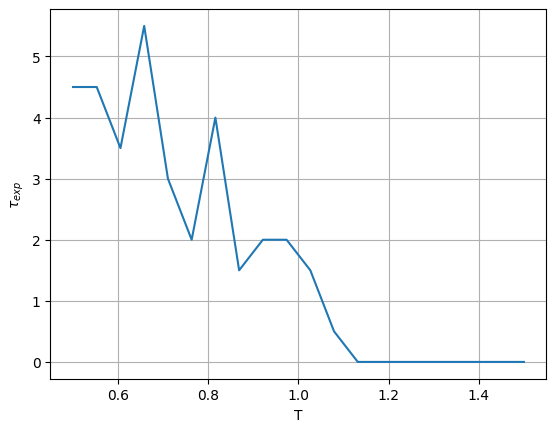

In [ ]:
max_taus = np.zeros(tau_w.shape[0])

for i, t in enumerate(tau_w):
    t1 = np.argmax(t < np.exp(-1))
    t3 = np.argmax(t < np.exp(-3))
    max_taus[i] = (t3 - t1) / 2

plt.plot(T, max_taus)
plt.xlabel("T")
plt.ylabel(r"$\tau_{exp}$")
plt.grid()
plt.show()